<a href="https://www.kaggle.com/code/mcpenguin/world-happiness-data-cleaning-eda?scriptVersionId=143234854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

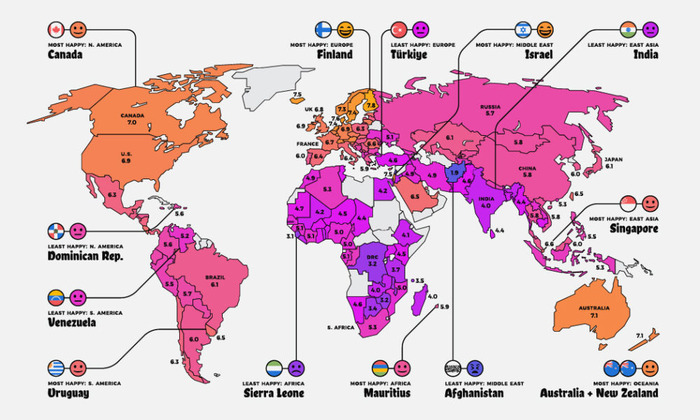

*Image source: Visual Capitalist - The World's Happiest Countries in 2023*

# World Happiness Report - Data Cleaning + EDA 🚀

In this notebook, we explore the world happiness report dataset. We will first clean the numerous data sources before aggregating them into one giant dataset, and then proceed to perform analysis. During our data exploration, we will consult external sources to better understand the context behind certain trends we observe, which will help us learn more about world events.

## Some of my other work

### Notebooks

- [Butterfly Image Classification](https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87)
- [Palmer Penguin EDA](https://www.kaggle.com/code/mcpenguin/palmer-archipelago-antarctica-penguin-eda)
- [Smoking and Drinking EDA + Classification](https://www.kaggle.com/code/mcpenguin/smoking-drinking-prediction-tfdf-71)
- [Gaia Stellar Classification](https://www.kaggle.com/mcpenguin/gaia-stellar-classification-lightgbm-91-acc)
- [Precious Metals Stocks: EDA + Forecasting](https://www.kaggle.com/code/mcpenguin/precious-metals-stocks-eda-and-prediction)
- [Red Wine Quality EDA + Prediction](https://www.kaggle.com/code/mcpenguin/red-wine-quality-prediction)

### Datasets

- [The Complete Rollercoasters Dataset](https://www.kaggle.com/datasets/mcpenguin/rollercoasters)
- [Malaysian COVID-19 Data](https://www.kaggle.com/datasets/mcpenguin/malaysia-covid19)
- [Super Mario 64 Speedruns](https://www.kaggle.com/datasets/mcpenguin/super-mario-64-speedruns)

# Preamble

Before analyzing the data from the report, we should investigate the source: what is the report entailing anyway, and how is the data collected? From the report's [FAQ page](https://worldhappiness.report/faq/), we see the following explanation:

> [We] use data from the Gallup World Poll surveys from 2020 to 2022. They are based on answers to the main life evaluation question asked in the poll. This is called the Cantril ladder: it asks respondents to think of a ladder, with the best possible life for them being a 10 and the worst possible life being a 0. They are then asked to rate their own current lives on that 0 to 10 scale. The rankings are from nationally representative samples for the years 2020-2022. The number of people and countries surveyed varies year to year, but by and large more than 100,000 people in 130 countries participate in the Gallup World Poll each year. They are based entirely on the survey scores, using the Gallup weights to make the estimates representative. The sub-bars in the alternate version of Figure 2.1 show the estimated extent to which each of the six factors (levels of GDP, life expectancy, generosity, social support, freedom, and corruption) is estimated to contribute to making life evaluations higher in each country than in Dystopia. Dystopia is a hypothetical country with values equal to the world’s lowest national averages for each of the six factors (see FAQs: What is Dystopia?). The sub-bars have no impact on the total score reported for each country but are just a way of explaining the implications of the model estimated in Table 2.1. People often ask why some countries rank higher than others—the sub-bars (including the residuals, which show what is not explained) attempt to answer that question.

In essence, the report uses data from a global poll and computes rankings for certain "happiness" metrics for each country. This is what our dataset is about.

Moreover, there are references to an imaginary country, "Dystopia", in our dataset. The FAQ also gives information about this:

> Dystopia is an imaginary country that has the world’s least-happy people. The purpose in establishing Dystopia is to have a benchmark against which all countries can be favourably compared (no country performs more poorly than Dystopia) in terms of each of the six key variables, thus allowing each sub-bar to be of positive (or zero, in six instances) width. The lowest scores observed for the six key variables, therefore, characterise Dystopia. Since life would be very unpleasant in a country with the world’s lowest incomes, lowest life expectancy, lowest generosity, most corruption, least freedom, and least social support, it is referred to as “Dystopia,” in contrast to Utopia.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

import geojson
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

from urllib.request import urlopen

# Load World GeoJSON

For this notebook, we will be using a GeoJSON of the world's countries for data visualization purposes.

In [ ]:
geojson_link = "/kaggle/input/world-geojson/custom.geo.json"
gdf = gpd.read_file(geojson_link)
    
gdf.head()

# Load Datasets

Weirdly, there does not seem to be data for the year 2014. Looking at the data briefly, it seems like

* The yearly reports contain information about the countries' scores on certain metrics; and

* The overall *index* report only contains information about the rankings of the countries in terms of global happiness.

Thus, it seems natural to combine the index report and the multiple yearly reports into one giant dataset for analysis. Before that, however, we will do some "sanity chekcs" on the individual datasets to examine their structure and determine if any processing is required before merging all the datasets.

## First Look

In [ ]:
input_dir = "../input/world-happiness-report-2013-2023"
years = list(range(2015,2024))

yearly_reports = {year: pd.read_csv(os.path.join(input_dir, f"World Happiness Report {year}.csv")) for year in years}
index_report = pd.read_csv(os.path.join(input_dir, f"WorldHappinessIndex2013-2023.csv"))

yearly_reports[2021].head()

In [ ]:
index_report.head()

## Column Information

The initial dataset brief did not really explain the meanings behind the columns, which are essential to do any analysis on the data. From the [Global Happiness report statistical appendix for 2023](https://happiness-report.s3.amazonaws.com/2023/WHR+23_Statistical_Appendix.pdf) and the [actual report itself](https://happiness-report.s3.amazonaws.com/2023/WHR+23.pdf), we are able to get a better explanation behind the different columns.

* The **Ladder Score** represents the national average response to the "question of life" evaluations from the global survey, with the corresponding values of the `standard error`. We also see that the bounds of the 95% confidence interval for the ladder score are also given, which is roughly equal to the ladder score plus/minus 2 times of the standard error.

* **GDP per capita** is the Gross Domestic Product, or how much each country produces, divided by the number of people in the country.

* **Social support** is a measure of whether an individual have someone to count on in times of trouble.

* **Healthy life expectancy** is a measure of the individual's life expectancy, in addition to taking their physical and mental health into account.

* **Freedom to make Life Choices** is a measure of the satisfaction of an individual's freedom to choose what to do with their life, which also encompasses their human rights.

* **Generosity** is a measure of how generous an individual with; e.g. whether they donated money to a charity in the past month.

* **Perception of Corruption** is a measure of people's perceptions of corruption in their governments, and whether they have trust in their governments and the benevolence of others.

## Dataset Information

We can investigate the number of rows and the quantity of missing values in each dataset by calling the `info` command.

In [ ]:
for year, df in yearly_reports.items():
    print(f"Information for {year}:")
    print(df.info())
    print()
    print("-"*30)

From this analysis, we see a couple of observations:

* There are almost no missing values throughout all the yearly reports.

* The latest world happiness reports seem to have more data than the earlier ones (which would correspond to more countries).

* The column names throughout the report are inconsistent. This reflects that the methodologies for each yearly report evolves over time, and we might not be able to compare the metrics directly. However, they should be similar enough that we can still see any patterns that emerge from the data. In particular, we will need to manually pre-process these column names before combining the datasets.

* Some of the earlier happiness reports contain ranking information explicitly, whereas the later ones do not. However, this is something that we would be able to calculate based on the corresponding ladder scores for each year.

* The data from 2022 is missing most of the parameters that are present in the other datasets.

* Some datasets are missing region information (the sub-continent/continent they are located at). However, we only really care about the countries; the region information can be added from a separate dataset if needed later on in our analysis.

* The "Explained by" column, from a glance, seems to be the proportion of the ladder score that the corresponding metric contributes.  However, as they are only present in the data from 2020 onwards, we might not be able to do proper analysis on them. Thus, we can disregard these variates in our analysis (for now).


# Data Cleaning

Before we can do any further analysis, we need to clean our data as the current state of the data is very messy. This is tedious, but is very important in our data processing pipeline, since it can help us eliminate potential sources of confusion when we actually begin data exploration.

## Column Manipulation

As mentioned, in order to merge our datasets, we will need to align the column names across the different yearly datasets. We will also drop any columns that are not needed. This is a *lot* of manual work, but data cleaning is part of the data science experience. 

For consistency, we will use the following column names:

```
Ladder score
Standard error of ladder score
Rank
upperwhisker
lowerwhisker
Logged GDP per capita
Social support
Healthy life expectancy
Freedom to make life choices
Generosity
Perceptions of corruption  
Dystopia + residual
```

In [ ]:
# 2015
yearly_reports[2015] = yearly_reports[2015].rename(columns={
    "Country": "Country name",
    "Happiness Score": "Ladder score",
    "Happiness Rank": "Rank",
    "Standard Error": "Standard error of ladder score",
    "Family": "Social support",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Healthy life expectancy",
    "Freedom": "Freedom to make life choices",
    "Trust (Government Corruption)": "Perceptions of corruption",
    "Dystopia Residual": "Dystopia + residual"
}).drop(columns=["Region"], errors='ignore')
yearly_reports[2015]["Logged GDP per capita"] = yearly_reports[2015]["GDP per Capita"].apply(np.log)
yearly_reports[2015] = yearly_reports[2015].drop(columns=["GDP per Capita"])
yearly_reports[2015]["upperwhisker"] = yearly_reports[2015]["Ladder score"] + 2 * yearly_reports[2015]["Standard error of ladder score"]
yearly_reports[2015]["lowerwhisker"] = yearly_reports[2015]["Ladder score"] - 2 * yearly_reports[2015]["Standard error of ladder score"]

# 2016
yearly_reports[2016] = yearly_reports[2016].rename(columns={
    "Country": "Country name",
    "Happiness Score": "Ladder score",
    "Happiness Rank": "Rank",
    "Standard Error": "Standard error of ladder score",
    "Lower Confidence Interval": "lowerwhisker",
    "Upper Confidence Interval": "upperwhisker",
    "Family": "Social support",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Healthy life expectancy",
    "Freedom": "Freedom to make life choices",
    "Trust (Government Corruption)": "Perceptions of corruption",
    "Dystopia Residual": "Dystopia + residual"
}).drop(columns=["Region"], errors='ignore')
yearly_reports[2016]["Logged GDP per capita"] = yearly_reports[2016]["GDP per Capita"].apply(np.log)
yearly_reports[2016] = yearly_reports[2016].drop(columns=["GDP per Capita"])

# 2017
yearly_reports[2017] = yearly_reports[2017].rename(columns={
    "Country": "Country name",
    "Happiness.Score": "Ladder score",
    "Standard Error": "Standard error of ladder score",
    "Happiness.Rank": "Rank",
    "Whisker.low": "lowerwhisker",
    "Whisker.high": "upperwhisker",
    "Family": "Social support",
    "Economy..GDP.per.Capita.": "GDP per Capita",
    "Health..Life.Expectancy.": "Healthy life expectancy",
    "Freedom": "Freedom to make life choices",
    "Trust..Government.Corruption.": "Perceptions of corruption",
    "Dystopia.Residual": "Dystopia + residual"
})
yearly_reports[2017]["Logged GDP per capita"] = yearly_reports[2017]["GDP per Capita"].apply(np.log)
yearly_reports[2017] = yearly_reports[2017].drop(columns=["GDP per Capita"])

# 2018 - standard error not given
yearly_reports[2018] = yearly_reports[2018].rename(columns={
    "Country or region": "Country name",
    "Score": "Ladder score",
    "Overall rank": "Rank",
    "Standard Error": "Standard error of ladder score",
    "GDP per capita": "GDP per Capita",
})
yearly_reports[2018]["Logged GDP per capita"] = yearly_reports[2018]["GDP per Capita"].apply(np.log)
yearly_reports[2018] = yearly_reports[2018].drop(columns=["GDP per Capita"])

# 2019 - standard error not given
yearly_reports[2019] = yearly_reports[2019].rename(columns={
    "Country or region": "Country name",
    "Score": "Ladder score",
    "Overall rank": "Rank",
    "GDP per capita": "GDP per Capita",
})
yearly_reports[2019]["Logged GDP per capita"] = yearly_reports[2019]["GDP per Capita"].apply(np.log)
yearly_reports[2019] = yearly_reports[2019].drop(columns=["GDP per Capita"], errors='ignore')

# 2020
yearly_reports[2020] = yearly_reports[2020].drop(columns=["Regional indicator"], errors='ignore')
yearly_reports[2020]['Rank'] = yearly_reports[2020]['Ladder score'].rank(method='min', ascending=False)

# 2021
yearly_reports[2021] = yearly_reports[2021].drop(columns=["Regional indicator"], errors='ignore')
yearly_reports[2021]['Rank'] = yearly_reports[2021]['Ladder score'].rank(method='min', ascending=False)

# 2022
yearly_reports[2022] = yearly_reports[2022].rename(columns={
    "Country": "Country name",
    "RANK": "Rank",
    "Happiness score": "Ladder score",
    "Whisker-high": "upperwhisker",
    "Whisker-low": "lowerwhisker",
    "Dystopia (1.83) + residual": "Dystopia + residual"
})

# 2023
yearly_reports[2023]['Rank'] = yearly_reports[2023]['Ladder score'].rank(method='min', ascending=False)

Unfortunately, even with this, we see that a lot of column variates are still missing. For example, the years 2018 and 2019 have no standard error information, so we are unable to build a confidence interval. That being said, we could estimate the data using linear interpolation later on, assuming these intervals do not really change over time.

We can check that our manipulation was successful by checking the columns of the revised yearly reports:

In [ ]:
for year, report in yearly_reports.items():
    print(f"Columns for {year}:")
    print(list(report.columns))
    print("-"*30)

## Inter-Data Country Name Discrepancies

To merge our datasets together, we will need to use the countries and year as an index. Thus, we should check for any discrepancies of the country names between our various reports, so that we can rectify these in our feature engineering.

We will use the report from 2023 as our "reference" dataset.

In [ ]:
ref_year = 2023
def print_country_discrepancies(ref_year):
    for year in years:
        yearly_report = yearly_reports[year]
        ref_yearly_report = yearly_reports[ref_year]

        diff1 = [x for x in yearly_report["Country name"].unique() if x not in ref_yearly_report["Country name"].unique()]
        diff2 = [x for x in ref_yearly_report["Country name"].unique() if x not in yearly_report["Country name"].unique()]

        print(f"Year: {year}")
        print(f"In yearly report but not in ref yearly report: {diff1}")
        print(f"In ref yearly report but not in yearly report: {diff2}")
        print("-"*30)
        
print_country_discrepancies(ref_year)

Woah, that's a lot of discrepancies. This should be expected, as over the course of 2015-2023, multiple countries have changed their names. Additionally, there are special cases like Hong Kong and Taiwan, that due to geo-poltical reasons have differing names between the reports.

Realistically, we will just ensure that the names of (most of) the countries in the 2023 report have been rectified in the earlier reports, so that the country names match. Again, this is pretty tedious, but this is part of data cleaning.

We will use the 2023 report as our "reference" report.

In [ ]:
# discrepancies is in the form {year: discrepancy}
# discrepancies[year] is in the form of {old: new}, where "old" is the name in the yearly report,
# and "new" is the name in the reference yearly report (i.e. the report from 2023)

discrepancies = {}
discrepancies[2015] = {
    "Czech Republic": "Czechia", # https://www.timeout.com/news/the-czech-republic-is-changing-its-name-heres-why-022123
    "Taiwan": "Taiwan Province of China", # https://en.wikipedia.org/wiki/Taiwan_Province,_People%27s_Republic_of_China
    "Hong Kong": "Hong Kong S.A.R. of China",
    "Macedonia": "North Macedonia", # https://en.wikipedia.org/wiki/Macedonia_naming_dispute
    "Palestinian Territories": "State of Palestine",
    "Turkey": "Turkiye", # https://theconversation.com/why-does-turkey-want-other-countries-to-start-spelling-its-name-turkiye-199390
}
discrepancies[2016] = discrepancies[2015]
discrepancies[2017] = {
    "Czech Republic": "Czechia",
    "Hong Kong S.A.R., China": "Hong Kong S.A.R. of China",
    "Macedonia": "North Macedonia", # https://en.wikipedia.org/wiki/Macedonia_naming_dispute
    "Palestinian Territories": "State of Palestine",
    "Turkey": "Turkiye", # https://theconversation.com/why-does-turkey-want-other-countries-to-start-spelling-its-name-turkiye-199390
}
discrepancies[2018] = discrepancies[2015]
discrepancies[2019] = discrepancies[2015]
discrepancies[2020] = discrepancies[2015]
discrepancies[2021] = {
    "Czech Republic": "Czechia",
    "Palestinian Territories": "State of Palestine",
    "Turkey": "Turkiye"
}
discrepancies[2022] = {
    "Luxembourg*": "Luxembourg",
    "Guatemala*": "Guatemala",
    "Palestinian Territories*": "State of Palestine",
    "Turkey": "Turkiye",
    "Niger*": "Niger",
    "Chad*": "Chad",
    "Liberia*": "Liberia",
    "Gambia*": "Gambia",
    "Comoros*": "Comoros",
    "Madagascar*": "Madagascar",
    "Botswana*": "Botswana"
}

for year, discrepancy in discrepancies.items():
    for old, new in discrepancy.items():
        yearly_reports[year].loc[yearly_reports[year]["Country name"] == old, "Country name"] = new

We should see less discrepancies with the countries now. In particular, there should be no cases of countries with one name in one report, and another name in the reference report.

In [ ]:
print_country_discrepancies(ref_year)

## Adding the Year to the Yearly Reports

Before combining our yearly reports, we should add the year information to each dataset.

In [ ]:
for year, report in yearly_reports.items():
    report["Year"] = year

## Combining the Yearly Reports Together

After all our data cleaning, we are now ready to combine the yearly reports together into one giant dataset.

In [ ]:
agg_report = pd.concat(yearly_reports.values())
agg_report.sample(20)

We will also only consider countries from the 2023 dataset, so we can filter out all the data points whose country does not get examined in the 2023 report:

In [ ]:
countries = agg_report.loc[agg_report["Year"] == 2023, "Country name"]
agg_report = agg_report[agg_report["Country name"].isin(countries)]

We also need to reindex our dataframe since we constructed it using concatenation:

In [ ]:
agg_report.index = range(0, agg_report.shape[0])

Let's examine this dataset using the `info` command to get a sense of its shape, as well as quantify the frequency of missing values:

In [ ]:
agg_report.info()

# Exploratory Data Analysis

We are finally ready to begin exploring the data. 

## Mean Ladder Score

A potential first variate we can look at is the mean ladder score for each year across all the countries.

In [ ]:
agg_report_grped = agg_report.groupby(by="Year").mean(numeric_only=True)
ax = sns.lineplot(data=agg_report_grped, x="Year", y="Ladder score", marker="o")
ax.set_ylabel("Mean ladder score")
plt.show()

We see that the mean ladder score has increased throughout the years.

## Distribution of Ladder Scores by Year

We might also be interested in the distribution of ladder scores across the various countries by year.

In [ ]:
plt.figure(figsize=(10,15))
agg_report["CatYear"] = agg_report["Year"].astype('category')
ax = sns.boxenplot(data=agg_report, x="Ladder score", y="CatYear")
ax.set_ylabel("Year")
plt.show()

## Distribution of Ladder Scores per Country

Although this plot may not offer as much insight as the below plots, it is too aesthetically pleasing to not include:

In [ ]:
plt.figure(figsize=(10, 60))
ax = sns.boxenplot(data=agg_report, x="Ladder score", y="Country name")
plt.show()

## Ladder Score + Rank for Selected Countries

Another potential attribute we can look at is the ladder scores for certain countries. Since there are over 120+ countries in our dataset, plotting them all on a single graph might be overwhelming. As such, we can instead plot a handful of countries instead.

In [ ]:
plt.figure(figsize=(12,8))
countries_of_interest = ["Japan", "Malaysia", "Thailand", "Australia", "United States", "Canada", "Egypt", "Argentina", "France", "Russia", "Italy"]

agg_report_filtered = agg_report[agg_report["Country name"].isin(countries_of_interest)]
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Ladder score", hue="Country name", marker="o")
ax.set(title="Ladder scores for selected countries")
plt.show()

We might also want to investigate how the rankings of these countries have changed over the timespan.

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Rank", hue="Country name", marker="o")
ax.set(title="Rank for selected countries")
plt.show()

We see that the ranks and ladder scores of countries stay relatively around the same, with some exceptions. For example, Malaysia had a sharp decline in its ladder score from 2018 to 2019.

Given this, an attribute of interest that might be interesting to investigate next might be the largest/smallest differences in ladder score between consecutive years.

## Ladder Scores + Ranks of Happiest Countries

We could next investigate the ladder scores and ranks of the happiest countries, which we could define as having the highest happiness ladder scores in 2023.

In [ ]:
happiest_countries = agg_report[agg_report["Year"] == 2023].sort_values(by="Ladder score", ascending=False).head(10)
happiest_countries[["Country name", "Ladder score"]]

We notice that 8 out of the top 10 are in Europe, and furthermore 5 out of these are from Scandanavia (Finland, Denmark, Iceland, Sweden, Norway). These should not be unexpected, as these countries are renowned for their high quality of life.

In [ ]:
plt.figure(figsize=(12,8))
agg_report_filtered = agg_report[agg_report["Country name"].isin(happiest_countries["Country name"])]
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Ladder score", hue="Country name", marker="o")
ax.set(title="Ladder scores for happiest countries")
plt.show()

We can similarly investigate the countries' ranks over time:

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Rank", hue="Country name", marker="o")
ax.set(title="Ranks for happiest countries")
plt.show()

## Ladder Scores + Ranks of Saddest Countries

Similarly, we can investigate the ladder scores and ranks of the saddest countries, which we could define as having the lowest happiness ladder scores in 2023.

In [ ]:
saddest_countries = agg_report[agg_report["Year"] == 2023].sort_values(by="Ladder score", ascending=True).head(10)
saddest_countries[["Country name", "Ladder score"]]

We see that 8 out of 10 of these are from Africa, which historically has been war-torn, devastated by colonialism, and rampant with inequality and corruption. The bottom two countries (Afghanistan and Lebanon) being devastated by numerous wars ([Afghanistan war](https://www.britannica.com/event/Afghanistan-War), [Lebanon 2006 war](https://en.wikipedia.org/wiki/2006_Lebanon_War)).

In [ ]:
plt.figure(figsize=(12,8))
agg_report_filtered = agg_report[agg_report["Country name"].isin(saddest_countries["Country name"])]
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Ladder score", hue="Country name", marker="o")
ax.set(title="Ladder scores for saddest countries")
plt.show()

We see that the trend for many of these countries is a sharp decline downward. This should be expected - if the measured *happiness* score is low, it usually indicates low levels of freedom, human rights and high levels of government corruption. Without external intervention, it is only natural that these factors will lead to a negatively reinforcing  spiral that further exacerbates the sadness in the country.

Interestingly, the ladder scores of Afghanistan and Lebanon were relatively higher, but then dropped significantly starting from around 2017. If we consult external sources, we can see roughly why this is the case:

* **Afghanistan**: After the US occupation of the country, which ended in 2021, the Tailban took power in August 2021. They imposed numerous rules and policies that violated human rights, especially for girls and women. They also repressed freedom of speech, closed forcibly civil society organizations, and dismantled human-rights centred government offices. ([source](https://www.hrw.org/world-report/2023/country-chapters/afghanistan))

* **Lebanon**: Lebanon is currently experiencing a financial crisis that roughly started around 2019, and was further exacerbated by the COVID-19 pandemic, the 2020 Beirut port explosion and the Russian invasion of Ukraine. It was further devastated by US sanctions targeting Syria's government and the Iran-backed Hezbollah. In particular, its currency has been devalued by 90%, with triple-digits levels of inflation. ([source](https://en.wikipedia.org/wiki/Lebanese_liquidity_crisis))

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Rank", hue="Country name", marker="o")
ax.set(title="Ranks for saddest countries")
plt.show()

## Most Extreme Differences of Ladder Score

We alluded to this attribute earlier, but something we could also investigate are the most extreme differences of a country's ladder score between years. 

In [ ]:
diff_report = agg_report.merge(agg_report, how="cross", suffixes=("Start", "End"))
diff_report = diff_report[
    (diff_report["Country nameStart"] == diff_report["Country nameEnd"]) &
    (diff_report["YearStart"] < diff_report["YearEnd"])]
diff_report = diff_report.rename(columns={
    "YearStart": "Start year",
    "YearEnd": "End year",
    "Country nameStart": "Country name",
    "Ladder scoreStart": "Start year ladder score",
    "Ladder scoreEnd": "End year ladder score",
})
diff_report = diff_report[["Start year", "End year", "Country name", 
             "Start year ladder score", "End year ladder score"]]
diff_report["Difference in ladder score"] = diff_report["End year ladder score"] - diff_report["Start year ladder score"]
diff_report.sample(10)

### Most Positive Differences

We can now find the tuples `(start_year, end_year, country)` such that the difference in the ladder score was the most positive:

In [ ]:
most_positive_diff = diff_report.sort_values(by="Difference in ladder score", ascending=False).head(15)
most_positive_diff

We see that this leaderboard is dominated by a few countries. Let's try again, but this time group the same countries together:

In [ ]:
country_max_indices = diff_report.groupby(by="Country name")["Difference in ladder score"].idxmax()
most_positive_diff = (
    diff_report.loc[country_max_indices]
    .sort_values(by="Difference in ladder score", ascending=False)
    .head(10))
most_positive_diff

Let's plot the trajectories of the ladder scores of countries from this list to see how the trends look like graphically.

In [ ]:
plt.figure(figsize=(12,8))
agg_report_filtered = agg_report[agg_report["Country name"].isin(most_positive_diff["Country name"])]
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Ladder score", hue="Country name", marker="o")
ax.set(title="Ladder scores for most positive difference countries")
plt.show()

Let's look at the top 2 countries from this list, and try to investigate possible sources for the happiness score increases their countries experienced. 

1. **Benin**: From the year 2015 to 2020, their happiness score increased by 1.876. From an article I found online, it seems like Patrice Talon's rise to power in 2016 introduced sweeping reforms that helped improve the living conditions of Benin's citizens, which would increase their overall happiness. However, it seems like the happiness has since fallen down since then. ([source](https://www.orishas-finance.com/actualite/3008?lang=en))

2. **Ivory Coast**: From the year 2015 to 2021, their happiness score increased by 1.65. From an article I found online, it seems like economic growth is helping drive the country's overall happiness up. ([source](https://www.ecofinagency.com/public-management/2303-43479-cote-divoire-is-the-happiest-country-in-west-africa-according-to-the-whr-2022))

### Most Negative Differences

We can now find the tuples `(start_year, end_year, country)` such that the difference in the ladder score was the most negative, grouping again by country:

In [ ]:
country_min_indices = diff_report.groupby(by="Country name")["Difference in ladder score"].idxmin()
most_negative_diff = (
    diff_report.loc[country_min_indices]
    .sort_values(by="Difference in ladder score", ascending=True)
    .head(10))
most_negative_diff

We can plot the ladder scores for these countries as well:

In [ ]:
plt.figure(figsize=(12,8))
agg_report_filtered = agg_report[agg_report["Country name"].isin(most_negative_diff["Country name"])]
ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Ladder score", hue="Country name", marker="o")
ax.set(title="Ladder scores for most negative difference countries")
plt.show()

## Map of Ladder Scores + Ranks per Year

We can also plot the ladder scores and ranks graphically on the world map per year. Let's first take a look at the geo-dataframe of the world's countries that we downloaded earlier:

In [ ]:
gdf.head()

Let's see how our GeoJSON file looks like as a map:

In [ ]:
gplt.polyplot(
    gdf, 
    edgecolor='black', facecolor='lightgrey', linewidth=.3,
    figsize=(12, 8))
plt.show()

For the visualization to work, we will need the countries on both dataframes to match. As such, we should check for any discrepancies in the country names between our aggregate report and this geo-dataframe.

In [ ]:
# gdf["name"]

diff1 = [x for x in countries if x not in gdf["sovereignt"].unique()]
diff2 = [x for x in gdf["sovereignt"].unique() if x not in countries]
diff1.sort()
diff2.sort()
print(f"Countries in agg report but not in gdf: {diff1}")
print()
print(f"Countries in gdf but not in agg report: {diff2}")

We see that our world map excludes some of the countries in our dataset - we unfortunately cannot really do anything about this. However, we will be able to rectify some of the countries with "duplicate" names in both datasets.

In [ ]:
def rename_countries(country_dict):
    for old, new in country_dict.items():
        gdf.loc[gdf["sovereignt"] == old, "sovereignt"] = new

rename_countries({
    "United States of America": "United States",
    "Czech Republic": "Czechia",
    "Democratic Republic of the Congo": "Congo (Kinshasa)",
    "Republic of the Congo": "Congo (Brazzaville)",
    "United Republic of Tanzania": "Tanzania"
})

We can now merge our geo-dataframe and aggregated report together.

In [ ]:
gdf = gdf.rename(columns={"sovereignt": "Country name"})
geo_agg_report = gdf.merge(agg_report, on=["Country name"])
geo_agg_report.sample(10)

We can now plot a choropleth map of the countries' ladder scores.

In [ ]:
plt.figure(figsize=(12, 8))
gplt.choropleth(
    geo_agg_report[geo_agg_report["Year"] == 2023],
    hue="Ladder score", 
    edgecolor='black',
    cmap='Blues',
    legend=True,
    linewidth=.3)
plt.show()

We can similarly plot a map of the countries' ranks.

In [ ]:
plt.figure(figsize=(12, 8))
gplt.choropleth(
    geo_agg_report[geo_agg_report["Year"] == 2023],
    hue="Rank", 
    edgecolor='black',
    cmap='Blues',
    legend=True,
    linewidth=.3)
plt.show()

## Social Support

We can next investigate the distribution of social support. Firstly, we can see how the mean social support has changed over the years:

In [ ]:
agg_report_grped = agg_report.groupby(by="Year").mean(numeric_only=True)
ax = sns.lineplot(data=agg_report_grped, x="Year", y="Social support", marker="o")
ax.set_ylabel("Mean social support")
plt.show()

We can see the distribution of social support scores across the years:

In [ ]:
plt.figure(figsize=(10,15))
ax = sns.boxenplot(data=agg_report, x="Social support", y="CatYear")
ax.set_ylabel("Year")
plt.show()

Similarly, we can plot the social support across countries as well:

In [ ]:
plt.figure(figsize=(10,60))
ax = sns.boxenplot(data=agg_report, x="Social support", y="Country name")
plt.show()

## Social Support for Selected Countries

We can investigate the social support levels for the selected countries we investigated earlier:

In [ ]:
plt.figure(figsize=(12,8))
countries_of_interest = ["Japan", "Malaysia", "Thailand", "Australia", "United States", "Canada", "Egypt", "Argentina", "France", "Russia", "Italy"]
agg_report_filtered = agg_report[agg_report["Country name"].isin(countries_of_interest)]

ax = sns.lineplot(data=agg_report_filtered, x="Year", y="Social support", hue="Country name", marker="o")
ax.set(title="Social support for selected countries")
plt.show()

## Countries with Highest Social Support

We can investigate the countries with the highest social support (in 2023).

In [ ]:
highest_social_support_countries = agg_report[agg_report["Year"] == 2023].sort_values(by="Social support", ascending=False).head(10)
highest_social_support_countries[["Country name", "Social support", "Ladder score"]]

Unsurprisingly, many of the countries with the highest social support values also have high ladder scores.

## Countries with Lowest Social Support

We can also investigate the countries with the highest social support (in 2023).

In [ ]:
lowest_social_support_countries = agg_report[agg_report["Year"] == 2023].sort_values(by="Social support", ascending=True).head(10)
lowest_social_support_countries[["Country name", "Social support", "Ladder score"]]

Unsurprisingly, we see that many of the countries with low social support values also have low ladder scores.

Feel free to explore the other variates as well by copying and editing this notebook.

## Correlation Matrix

We can plot a correlation matrix of all the individual variates.

In [ ]:
sns.heatmap(agg_report.corr(numeric_only=True))
plt.show()

# Thank you for reading!